 **House Prices Prediction Simple Model**

This kernel is a basic approach to prediction of House Prices for the given dataset.

Importing the necessary packages.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import GridSearchCV,KFold,cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from scipy.stats import skew
from scipy.special import boxcox1p
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'train.csv']


**Reading the dataset**

In [2]:
X=pd.read_csv("./input/train.csv")
X_test=pd.read_csv("./input/test.csv")
X.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
X_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [4]:
X.shape,X_test.shape

((1460, 81), (1459, 80))

**Steps to create the model :-**
* Filling missing values
* Labeling, creating dummies and feature engineering
* Modelling

**Filling missing values**

Columns with missing values

In [5]:
X.isnull().sum()[X.isnull().sum()>0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [6]:
X_test.isnull().sum()[X_test.isnull().sum()>0]

MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64

Correlation matrix of features highly correlated with SalePrice feature.

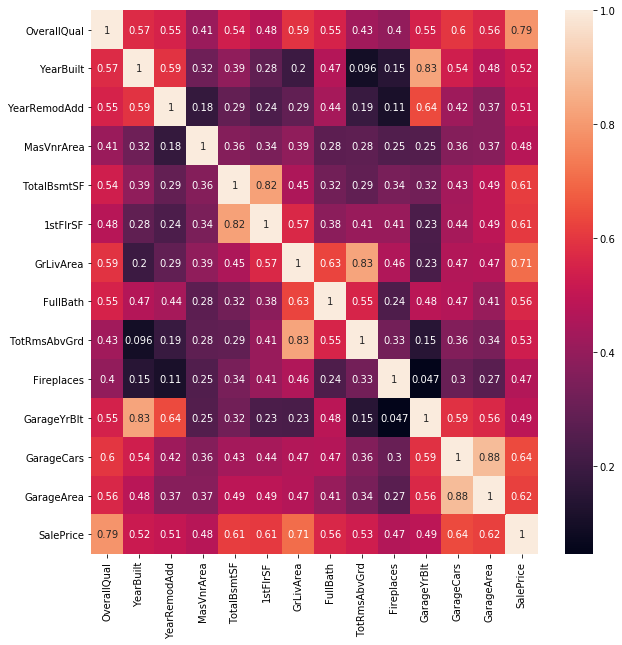

In [7]:
corr=X.corr()
plt.figure(figsize=(10,10))
sns.heatmap(X[corr.index[abs(corr['SalePrice'])>0.4]].corr(),annot=True)

In [8]:
fillnull={ 'PoolQC':'NoPool', 'MiscFeature':'NoMisc', 'Alley':'NoAlley', 'Fence':'NoFence', 'FireplaceQu':'NoFire' }
X.fillna(fillnull,inplace=True)
X_test.fillna(fillnull,inplace=True)

Dropping data points with above grouund living area greater than 4000 square feet.

In [9]:
X.drop(X[X.GrLivArea>4000].index.values,inplace=True)

Text(0,0.5,'LotFrontage')

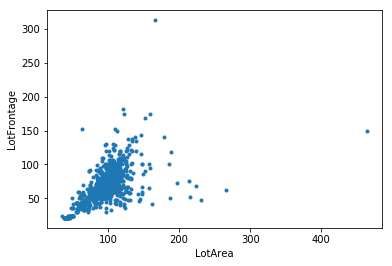

In [10]:
plt.plot((X.LotArea)**0.5,X.LotFrontage,'.')
plt.xlabel('LotArea')
plt.ylabel('LotFrontage')

In [11]:
X.drop(X[X.LotFrontage>300].index.values,inplace=True)
X.drop(X[X.LotArea>100000].index.values,inplace=True)
X.shape

(1451, 81)

Text(0,0.5,'LotFrontage')

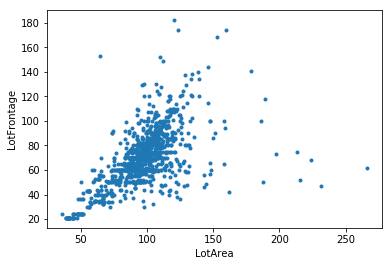

In [12]:
plt.plot((X.LotArea)**0.5,X.LotFrontage,'.')
plt.xlabel('LotArea')
plt.ylabel('LotFrontage')

Now filling missing missing values in LotFontage by linear regression between square root of LotArea and LotFrontage by using the logic that area is proportinal to square of length.

In [13]:
reg=LinearRegression()
reg.fit(((X[(X.LotArea<35000) & (X.LotFrontage<200)].LotArea)**0.5).values.reshape(-1,1),X[(X.LotArea<35000) & (X.LotFrontage<200)].LotFrontage.values)
reg.intercept_,reg.coef_[0]

(-2.9214562238702797, 0.7608583491196361)

In [14]:
X.loc[X.LotFrontage.isnull(),'LotFrontage']=reg.predict((X[X.LotFrontage.isnull()].LotArea.values.reshape(-1,1))**0.5)
X_test.loc[X_test.LotFrontage.isnull(),'LotFrontage']=reg.predict((X_test[X_test.LotFrontage.isnull()].LotArea.values.reshape(-1,1))**0.5)

In [15]:
X_test.GarageYrBlt.describe()

count    1381.000000
mean     1977.721217
std        26.431175
min      1895.000000
25%      1959.000000
50%      1979.000000
75%      2002.000000
max      2207.000000
Name: GarageYrBlt, dtype: float64

Max value of Garbage Year Built is 2207 in test set which is not possible so correcting these values.

In [16]:
X_test[X_test.GarageYrBlt>2018].GarageYrBlt

1132    2207.0
Name: GarageYrBlt, dtype: float64

In [17]:
X_test.GarageYrBlt.replace({2207:2007},inplace=True)

In [18]:
fillnull={ 'GarageType':'NoGarage', 'GarageFinish':'NoGarage', 'GarageQual':'NoGarage', 'GarageCond':'NoGarage', 'BsmtQual':'NoBsmt', 'BsmtCond':'NoBsmt', 'BsmtExposure':'NoBsmt', 'BsmtFinType1':'NoBsmt', 'BsmtFinType2':'NoBsmt' }
X.fillna(fillnull,inplace=True)
X_test.fillna(fillnull,inplace=True)

In [19]:
X.MasVnrType.fillna("None",inplace=True)
X_test.MasVnrType.fillna("None",inplace=True)
X.MasVnrArea.fillna(0,inplace=True)
X_test.MasVnrArea.fillna(0,inplace=True)
X.Electrical.fillna("SBrkr",inplace=True)

In [20]:
fillwithmode=['MSZoning','Utilities','Exterior1st','Exterior2nd','KitchenQual','Functional','SaleType']
for column in fillwithmode:
    mode=X[column].mode()[0]
    X_test[column].fillna(mode,inplace=True)
fillwithzero=['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']
for column in fillwithzero:
    X_test[column].fillna(0,inplace=True)
fillwithmedian=['GarageArea','GarageCars']
for column in fillwithmedian:
    median=X[column].median()
    X_test[column].fillna(median,inplace=True)
X_test.isnull().sum()[X_test.isnull().sum()>0]

GarageYrBlt    78
dtype: int64

In [21]:
X.isnull().sum()[X.isnull().sum()>0]

GarageYrBlt    81
dtype: int64

No need to fill GarageYrBlt column as it is similar to YearBuilt column except for the houses having no Garage, so we will drop this column in the end.

**Labeling, creating dummies and feature engineering**

In this part we will go through non numeric columns and labelling them in order of importance in case of cardinal featues, creating dummies in case of nominal featues. We will make new features and transforming wherever required.

In [22]:
le=LabelEncoder()
dummies=pd.get_dummies(X.MSZoning,prefix='MSZoning')
X=pd.concat([X,dummies],axis=1)
dummies=pd.get_dummies(X_test.MSZoning,prefix='MSZoning')
X_test=pd.concat([X_test,dummies],axis=1)
X.loc[:,'Street']=le.fit_transform(X.Street.values)
X_test.loc[:,'Street']=le.transform(X_test.Street.values)
mapping={'NoAlley':0,'Grvl':1,'Pave':2}
X.Alley.replace(mapping,inplace=True)
X_test.Alley.replace(mapping,inplace=True)
mapping={'IR3':0,'IR2':1,'IR1':2,'Reg':3}
X.LotShape.replace(mapping,inplace=True)
X_test.LotShape.replace(mapping,inplace=True)
mapping={'Low':0,'HLS':1,'Bnk':2,'Lvl':3}
X.LandContour.replace(mapping,inplace=True)
X_test.LandContour.replace(mapping,inplace=True)
X.drop('Utilities',axis=1,inplace=True)
X_test.drop('Utilities',axis=1,inplace=True)
dummies=pd.get_dummies(X.LotConfig,prefix='LotConfig')
X=pd.concat([X,dummies],axis=1)
dummies=pd.get_dummies(X_test.LotConfig,prefix='LotConfig')
X_test=pd.concat([X_test,dummies],axis=1)
X.loc[:,'LandSlope']=le.fit_transform(X.LandSlope.values)
X_test.loc[:,'LandSlope']=le.transform(X_test.LandSlope.values)
dummies=pd.get_dummies(X.Neighborhood,prefix='Neigh')
X=pd.concat([X,dummies],axis=1)
dummies=pd.get_dummies(X_test.Neighborhood,prefix='Neigh')
X_test=pd.concat([X_test,dummies],axis=1)

In [23]:
dummies=pd.get_dummies(X.Condition1,prefix='Cond1')
X=pd.concat([X,dummies],axis=1)
dummies=pd.get_dummies(X_test.Condition1,prefix='Cond1')
X_test=pd.concat([X_test,dummies],axis=1)
dummies=pd.get_dummies(X.Condition2,prefix='Cond2')
X=pd.concat([X,dummies],axis=1)
X['Cond2_RRNe']=0
dummies=pd.get_dummies(X_test.Condition2,prefix='Cond2')
X_test=pd.concat([X_test,dummies],axis=1)
X_test['Cond2_RRAe']=0
X_test['Cond2_RRAn']=0
X_test['Cond2_RRNn']=0
X_test['Cond2_RRNe']=0
conditions=X.Condition1.unique()
for cond in conditions:
    X['Cond_'+cond]=((X['Cond1_'+cond]+X['Cond2_'+cond])>0)*1
    X_test['Cond_'+cond]=((X_test['Cond1_'+cond]+X_test['Cond2_'+cond])>0)*1
    X.drop(['Cond1_'+cond,'Cond2_'+cond],axis=1,inplace=True)
    X_test.drop(['Cond1_'+cond,'Cond2_'+cond],axis=1,inplace=True)

In [24]:
dummies=pd.get_dummies(X.BldgType,prefix='BldgType')
X=pd.concat([X,dummies],axis=1)
dummies=pd.get_dummies(X_test.BldgType,prefix='BldgType')
X_test=pd.concat([X_test,dummies],axis=1)
dummies=pd.get_dummies(X.HouseStyle,prefix='HouseStyle')
X=pd.concat([X,dummies],axis=1)
dummies=pd.get_dummies(X_test.HouseStyle,prefix='HouseStyle')
dummies['HouseStyle_2.5Fin']=0
dummies.sort_index(axis=1,inplace=True)
X_test=pd.concat([X_test,dummies],axis=1)
dummies=pd.get_dummies(X.RoofStyle,prefix='RoofStyle')
X=pd.concat([X,dummies],axis=1)
dummies=pd.get_dummies(X_test.RoofStyle,prefix='RoofStyle')
X_test=pd.concat([X_test,dummies],axis=1)
dummies=pd.get_dummies(X.RoofMatl,prefix='RoofMatl')
X=pd.concat([X,dummies],axis=1)
dummies=pd.get_dummies(X_test.RoofMatl,prefix='RoofMatl')
dummies['RoofMatl_Roll']=0
dummies['RoofMatl_Membran']=0
dummies['RoofMatl_Metal']=0
dummies.sort_index(axis=1,inplace=True)
X_test=pd.concat([X_test,dummies],axis=1)

In [25]:
X.Exterior1st.unique()

array(['VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'BrkFace', 'WdShing',
       'CemntBd', 'Plywood', 'AsbShng', 'Stucco', 'BrkComm', 'AsphShn',
       'Stone', 'ImStucc', 'CBlock'], dtype=object)

In [26]:
X_test.Exterior1st.unique()

array(['VinylSd', 'Wd Sdng', 'HdBoard', 'Plywood', 'MetalSd', 'CemntBd',
       'WdShing', 'BrkFace', 'AsbShng', 'BrkComm', 'Stucco', 'AsphShn',
       'CBlock'], dtype=object)

In [27]:
X.Exterior2nd.unique()

array(['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng',
       'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc',
       'AsphShn', 'Stone', 'Other', 'CBlock'], dtype=object)

In [28]:
X_test.Exterior2nd.unique()

array(['VinylSd', 'Wd Sdng', 'HdBoard', 'Plywood', 'MetalSd', 'Brk Cmn',
       'CmentBd', 'ImStucc', 'Wd Shng', 'AsbShng', 'Stucco', 'CBlock',
       'BrkFace', 'AsphShn', 'Stone'], dtype=object)

As we can see in Exterior2nd feature 'WdShing' is misspelled as 'Wd Shng', 'BrkComm' is misspelled as 'Brk Cmn' & 'CemntBd' is misspelled as 'CmentBd', so we need to correct these in the dataset.

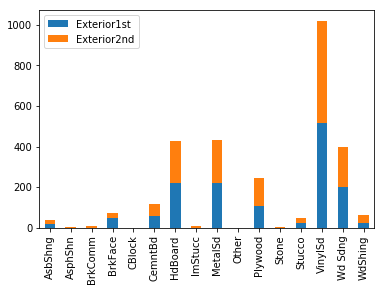

In [29]:
mapping={ 'Wd Shng':'WdShing','Brk Cmn':'BrkComm','CmentBd':'CemntBd' }
X.Exterior2nd.replace(mapping,inplace=True)
X_test.Exterior2nd.replace(mapping,inplace=True)
a=X.Exterior1st.value_counts()
b=X.Exterior2nd.value_counts()
c=pd.concat([a,b],axis=1,sort=True)
c.plot.bar(stacked=True)

In [30]:
dummies=pd.get_dummies(X.Exterior1st,prefix='Ext1')
dummies['Ext1_Other']=0
X=pd.concat([X,dummies],axis=1)
dummies=pd.get_dummies(X_test.Exterior1st,prefix='Ext1')
dummies['Ext1_ImStucc']=0
dummies['Ext1_Stone']=0
dummies['Ext1_Other']=0
X_test=pd.concat([X_test,dummies],axis=1)
dummies=pd.get_dummies(X.Exterior2nd,prefix='Ext2')
X=pd.concat([X,dummies],axis=1)
dummies=pd.get_dummies(X_test.Exterior2nd,prefix='Ext2')
dummies['Ext2_Other']=0
X_test=pd.concat([X_test,dummies],axis=1)
exteriors=X.Exterior2nd.unique()
for ext in exteriors:
    X['Ext_'+ext]=((X['Ext1_'+ext]+X['Ext2_'+ext])>0)*1
    X_test['Ext_'+ext]=((X_test['Ext1_'+ext]+X_test['Ext2_'+ext])>0)*1
    X.drop(['Ext1_'+ext,'Ext2_'+ext],axis=1,inplace=True)
    X_test.drop(['Ext1_'+ext,'Ext2_'+ext],axis=1,inplace=True)

In [31]:
dummies=pd.get_dummies(X.MasVnrType,prefix='MVT')
X=pd.concat([X,dummies],axis=1)
dummies=pd.get_dummies(X_test.MasVnrType,prefix='MVT')
X_test=pd.concat([X_test,dummies],axis=1)
mapping={ 'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0 }
X.ExterQual.replace(mapping,inplace=True)
X_test.ExterQual.replace(mapping,inplace=True)
X.ExterCond.replace(mapping,inplace=True)
X_test.ExterCond.replace(mapping,inplace=True)
dummies=pd.get_dummies(X.Foundation,prefix='Foundation')
X=pd.concat([X,dummies],axis=1)
dummies=pd.get_dummies(X_test.Foundation,prefix='Foundation')
X_test=pd.concat([X_test,dummies],axis=1)
X['NoBsmt']=(X.BsmtQual=='NoBsmt')*1
X_test['NoBsmt']=(X_test.BsmtQual=='NoBsmt')*1
mapping={ 'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0,'NoBsmt':-1 }
X.BsmtQual.replace(mapping,inplace=True)
X_test.BsmtQual.replace(mapping,inplace=True)
X.BsmtCond.replace(mapping,inplace=True)
X_test.BsmtCond.replace(mapping,inplace=True)
mapping={ 'Gd':4,'Av':3,'Mn':2,'No':1,'NoBsmt':0 }
X.BsmtExposure.replace(mapping,inplace=True)
X_test.BsmtExposure.replace(mapping,inplace=True)

Total finished area of the basement will be equal to the finished area of basement type 1 & 2. So creating a new feature 'BsmtFinSF' equal to the sum of 'BsmtFinSF1' & 'BsmtFinSF2'.

In [32]:
X['BsmtFinSF']=X.BsmtFinSF1+X.BsmtFinSF2
X_test['BsmtFinSF']=X_test.BsmtFinSF1+X_test.BsmtFinSF2

In [33]:
mapping={'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'NoBsmt':0}
X.BsmtFinType1.replace(mapping,inplace=True)
X_test.BsmtFinType1.replace(mapping,inplace=True)
X.BsmtFinType2.replace(mapping,inplace=True)
X_test.BsmtFinType2.replace(mapping,inplace=True)
dummies=pd.get_dummies(X.Heating,prefix='Heating')
X=pd.concat([X,dummies],axis=1)
dummies=pd.get_dummies(X_test.Heating,prefix='Heating')
dummies['Heating_OthW']=0
dummies['Heating_Floor']=0
dummies.sort_index(axis=1,inplace=True)
X_test=pd.concat([X_test,dummies],axis=1)
mapping={ 'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0 }
X.HeatingQC.replace(mapping,inplace=True)
X_test.HeatingQC.replace(mapping,inplace=True)
X.loc[:,'CentralAir']=le.fit_transform(X.CentralAir.values)
X_test.loc[:,'CentralAir']=le.transform(X_test.CentralAir.values)
dummies=pd.get_dummies(X.Electrical,prefix='Electrical')
X=pd.concat([X,dummies],axis=1)
dummies=pd.get_dummies(X_test.Electrical,prefix='Electrical')
dummies['Electrical_Mix']=0
dummies.sort_index(axis=1,inplace=True)
X_test=pd.concat([X_test,dummies],axis=1)

Creating a new feature 'TotalSF' equal to sum of area of all floors including basement.

In [34]:
X['TotalSF']=X['TotalBsmtSF']+X['1stFlrSF']+X['2ndFlrSF']
X_test['TotalSF']=X_test['TotalBsmtSF']+X_test['1stFlrSF']+X_test['2ndFlrSF']

In [35]:
mapping={ 'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0 }
X.KitchenQual.replace(mapping,inplace=True)
X_test.KitchenQual.replace(mapping,inplace=True)
mapping= {'Maj1':2,'Maj2':1,'Min1':5,'Min2':4,'Mod':3,'Sev':0,'Typ':6}
X.Functional.replace(mapping,inplace=True)
X_test.Functional.replace(mapping,inplace=True)
mapping={ 'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0,'NoFire':-1 }
X.FireplaceQu.replace(mapping,inplace=True)
X_test.FireplaceQu.replace(mapping,inplace=True)
X['NoGarage']=(X.GarageType=='NoGarage')*1
X_test['NoGarage']=(X_test.GarageType=='NoGarage')*1
dummies=pd.get_dummies(X.GarageType,prefix='GarageType')
X=pd.concat([X,dummies],axis=1)
dummies=pd.get_dummies(X_test.GarageType,prefix='GarageType')
X_test=pd.concat([X_test,dummies],axis=1)
mapping={'Fin':3,'RFn':2,'Unf':1,'NoGarage':0}
X.GarageFinish.replace(mapping,inplace=True)
X_test.GarageFinish.replace(mapping,inplace=True)
mapping={ 'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0,'NoGarage':-1 }
X.GarageQual.replace(mapping,inplace=True)
X_test.GarageQual.replace(mapping,inplace=True)
X.GarageCond.replace(mapping,inplace=True)
X_test.GarageCond.replace(mapping,inplace=True)
X.loc[:,'PavedDrive']=le.fit_transform(X.PavedDrive.values)
X_test.loc[:,'PavedDrive']=le.transform(X_test.PavedDrive.values)
mapping={'Ex':3,'Gd':2,'Fa':1,'NoPool':0}
X.PoolQC.replace(mapping,inplace=True)
X_test.PoolQC.replace(mapping,inplace=True)
dummies=pd.get_dummies(X.MiscFeature,prefix='Misc')
X=pd.concat([X,dummies],axis=1)
dummies=pd.get_dummies(X_test.MiscFeature,prefix='Misc')
dummies['Misc_TenC']=0
X_test=pd.concat([X_test,dummies],axis=1)
mapping={'GdPrv':4,'MnPrv':3,'GdWo':2,'MnWw':1,'NoFence':0}
X.Fence.replace(mapping,inplace=True)
X_test.Fence.replace(mapping,inplace=True)
mapping={1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
X.MoSold.replace(mapping,inplace=True)
X_test.MoSold.replace(mapping,inplace=True)
dummies=pd.get_dummies(X.MoSold,prefix='MoSold')
X=pd.concat([X,dummies],axis=1)
dummies=pd.get_dummies(X_test.MoSold,prefix='MoSold')
X_test=pd.concat([X_test,dummies],axis=1)
dummies=pd.get_dummies(X.YrSold,prefix='YrSold')
X=pd.concat([X,dummies],axis=1)
dummies=pd.get_dummies(X_test.YrSold,prefix='YrSold')
X_test=pd.concat([X_test,dummies],axis=1)
dummies=pd.get_dummies(X.SaleType,prefix='SaleType')
X=pd.concat([X,dummies],axis=1)
dummies=pd.get_dummies(X_test.SaleType,prefix='SaleType')
X_test=pd.concat([X_test,dummies],axis=1)
dummies=pd.get_dummies(X.SaleCondition,prefix='SaleCondition')
X=pd.concat([X,dummies],axis=1)
dummies=pd.get_dummies(X_test.SaleCondition,prefix='SaleCondition')
X_test=pd.concat([X_test,dummies],axis=1)
X.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,RL,65.0,8450,1,0,3,3,Inside,...,0,0,0,1,0,0,0,0,1,0
1,2,20,RL,80.0,9600,1,0,3,3,FR2,...,0,0,0,1,0,0,0,0,1,0
2,3,60,RL,68.0,11250,1,0,2,3,Inside,...,0,0,0,1,0,0,0,0,1,0
3,4,70,RL,60.0,9550,1,0,2,3,Corner,...,0,0,0,1,1,0,0,0,0,0
4,5,60,RL,84.0,14260,1,0,2,3,FR2,...,0,0,0,1,0,0,0,0,1,0


In [36]:
X_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1461,20,RH,80.0,11622,1,0,3,3,Inside,...,0,0,0,1,0,0,0,0,1,0
1,1462,20,RL,81.0,14267,1,0,2,3,Corner,...,0,0,0,1,0,0,0,0,1,0
2,1463,60,RL,74.0,13830,1,0,2,3,Inside,...,0,0,0,1,0,0,0,0,1,0
3,1464,60,RL,78.0,9978,1,0,2,3,Inside,...,0,0,0,1,0,0,0,0,1,0
4,1465,120,RL,43.0,5005,1,0,2,1,Inside,...,0,0,0,1,0,0,0,0,1,0


We will now delete the columns which are not required now.

In [37]:
column_drop=['Id','MSZoning','LotConfig','Condition1','Condition2','HouseStyle','RoofStyle','Exterior1st','Exterior2nd','MasVnrType','Foundation','Electrical','GarageType','MiscFeature','YrSold','SaleType','SaleCondition','GarageYrBlt','Neighborhood','BldgType','RoofMatl','Heating','MoSold']
X.drop(column_drop,axis=1,inplace=True)
X_test.drop(column_drop,axis=1,inplace=True)
Y=X.SalePrice
X.drop('SalePrice',axis=1,inplace=True)

In [38]:
skew(Y)

1.5786695664048098

As we can see our target variable Y is highly skewed, so we will apply log transformation on Y.

This is how log transformation of some variable x is done :-

**x' = log(1+x)**

In [39]:
Y=np.log1p(Y)
skew(Y)

0.0688217304305507

We can see above that skewness of Y is reduced after applying log transformation.

**Box-Cox Transformation :-**

We will now apply box cox transformation on features except for the dummy ones. Purpose of the transformation is to reduce skewness of features for modelling. These features have index 0 to 55,153 &165.

In [40]:
lst=list(range(56))
to_extend=[153,165]
lst.extend(to_extend)
skew_features=X.iloc[:,lst].apply(lambda x:skew(x)).sort_values(ascending=False)
skew_features_test=X_test.iloc[:,lst].apply(lambda x:skew(x)).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skew_features})
skewness_test = pd.DataFrame({'Skew' :skew_features_test})
skewness.head()

,Skew
MiscVal,24.444051
PoolQC,20.625942
PoolArea,17.474180
3SsnPorch,10.261120
LowQualFinSF,8.973279


In [41]:
skewness = skewness[abs(skewness) > 0.5].dropna()
feats=skewness.index.values.tolist()
lam=0.1
for feat in feats:
    X[feat]=boxcox1p(X[feat], lam)
    X_test[feat]=boxcox1p(X_test[feat], lam)
X.shape,X_test.shape

((1451, 211), (1459, 211))

In [42]:
X.head()

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LandSlope,OverallQual,OverallCond,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,5.084572,5.203879,14.699651,0.717735,0.0,1.486984,1.486984,0.0,7,1.962312,...,0,0,0,1,0,0,0,0,1,0
1,3.558821,5.518456,15.016794,0.717735,0.0,1.486984,1.486984,0.0,6,2.457309,...,0,0,0,1,0,0,0,0,1,0
2,5.084572,5.271613,15.416697,0.717735,0.0,1.161232,1.486984,0.0,7,1.962312,...,0,0,0,1,0,0,0,0,1,0
3,5.315312,5.084572,15.003735,0.717735,0.0,1.161232,1.486984,0.0,7,1.962312,...,0,0,0,1,1,0,0,0,0,0
4,5.084572,5.593439,16.026454,0.717735,0.0,1.161232,1.486984,0.0,8,1.962312,...,0,0,0,1,0,0,0,0,1,0


In [43]:
X_test.head()

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LandSlope,OverallQual,OverallCond,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,3.558821,5.518456,15.499509,0.717735,0.0,1.486984,1.486984,0.0,5,2.148140,...,0,0,0,1,0,0,0,0,1,0
1,3.558821,5.537509,16.027731,0.717735,0.0,1.161232,1.486984,0.0,6,2.148140,...,0,0,0,1,0,0,0,0,1,0
2,5.084572,5.399482,15.946893,0.717735,0.0,1.161232,1.486984,0.0,5,1.962312,...,0,0,0,1,0,0,0,0,1,0
3,5.084572,5.479706,15.113584,0.717735,0.0,1.161232,1.486984,0.0,6,2.148140,...,0,0,0,1,0,0,0,0,1,0
4,6.153943,4.599745,13.439540,0.717735,0.0,1.161232,0.717735,0.0,8,1.962312,...,0,0,0,1,0,0,0,0,1,0


**Modelling**

*  **Gradient Boosting Regression :-**

In [44]:
#parameters = {'max_depth':[2,3,4],'n_estimators':[2800,3000,3200],'max_features':['sqrt'],'loss':['huber'],'min_samples_leaf':[14,15,16],'min_samples_split':[9,10,11],'random_state':[0]}
parameters = {'max_depth':[3],'n_estimators':[3000],'max_features':['sqrt'],'loss':['huber'],'min_samples_leaf':[15],'min_samples_split':[10],'random_state':[0]}
model=GridSearchCV(GradientBoostingRegressor(),parameters,scoring='neg_mean_squared_error',cv=KFold(n_splits=7))
model.fit(X,Y)
Y_test1=model.predict(X_test)
Y_test1=np.exp(Y_test1)-1
((model.best_score_)*(-1))**0.5

0.11539289722417972

*  **Lasso Regression :-**

In [45]:
model=make_pipeline(RobustScaler(),Lasso(0.0004,random_state=0))
rmslerror=(-cross_val_score(model,X,Y,scoring='neg_mean_squared_error',cv=KFold(n_splits=7)))**0.5
print(rmslerror.mean())
model.fit(X,Y)
Y_test2=np.expm1(model.predict(X_test))

C:\Users\Nitin Sharma\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.10884620783962475


In next step we will take mean of the above models, advantage of taking mean is that error in one model is compensated by other model.

In [46]:
Y_test=(Y_test1+Y_test2)/2
submission=pd.DataFrame({'Id':range(1461,2920),'SalePrice':Y_test})
submission.to_csv('submit.csv',index=False)

Any suggestions are welcome.

***Thank You!***